# Homework 1

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_path = "../../datasets"

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()
    print(f"Using accelerator '{device}'")

    if device.type == "cuda":
        torch.backends.cudnn.deterministic = True
else:
    device = torch.device("cpu")
    print("WARN: No accelerator found, running on CPU")


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # normalize by mean and standard devia,
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = datasets.MNIST(
    data_path,
    train=True,
    download=True,
    transform=transform,
)

test_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    shuffle=False,
    drop_last=False,
    batch_size=10000,
)

Using accelerator 'mps'


In [2]:
class MnistCnn(torch.nn.Module):
    def __init__(self):
        super(MnistCnn, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.dropout1 = torch.nn.Dropout(p=0.25)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.fc1 = torch.nn.Linear(in_features=9216, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Log softmax rather than softmax due to negative log likelihood loss.
        # log_softmax rather than two separate operations for numerical stability
        output = torch.nn.functional.log_softmax(x, dim=1)

        return output

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [3]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

clients = 100
learning_rate = 0.01
active_clients_fraction = 0.1
local_epochs = 1
batch_size = 100
rounds = 10
assume_data_iid = True
seed = 10

In [4]:
from components.data_splitting import (
    index_uniformly,
    index_by_approximate_binary_target_partitions,
    partition_dataset,
)
from torch.utils.data import Subset


def determine_client_datasets(iid: bool, clients: int) -> list[Subset]:
    if iid:
        partition_index = index_uniformly(train_dataset, clients, seed)
    else:
        partition_index = index_by_approximate_binary_target_partitions(
            train_dataset, clients, seed
        )

    return partition_dataset(train_dataset, partition_index)

In [5]:
from fedavg import Server as FedAvgServer


def run_fedavg(
    iid: bool = assume_data_iid,
    rounds: int = rounds,
    clients: int = clients,
    active_clients_fraction: float = active_clients_fraction,
    learning_rate: float = learning_rate,
    batch_size: int = batch_size,
    local_epochs: int = local_epochs
) -> pd.DataFrame:
    partitions = determine_client_datasets(iid, clients)

    torch.manual_seed(0)
    server = FedAvgServer(
        device=device,
        model=MnistCnn().to(device),
        learning_rate=learning_rate,
        batch_size=batch_size,
        client_subsets=partitions,
        client_fraction=active_clients_fraction,
        local_epochs=local_epochs,
        seed=seed,
    )

    return server.run(rounds, test_loader).as_df()

In [6]:
from fedsgd import Server as FedSgdServer


def run_fedsgd(
    *,
    iid: bool = assume_data_iid,
    rounds: int = rounds,
    clients: int = clients,
    active_clients_fraction: float = active_clients_fraction,
    learning_rate: float = learning_rate
) -> pd.DataFrame:
    partitions = determine_client_datasets(iid, clients)

    torch.manual_seed(0)
    fedsgd_server = FedSgdServer(
        device=device,
        model=MnistCnn().to(device),
        client_subsets=partitions,
        active_clients_fraction=active_clients_fraction,
        learning_rate=learning_rate,
        seed=seed,
    )

    return fedsgd_server.run(rounds, test_loader).as_df()

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of up to around 0.1%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (for the different decentralized data learning parameters) weight and gradient FedSGD are equivalent.

#### Answer

In [7]:
client_fraction_variants = [0.5, 0.2]
learning_rate_variants = [0.01, 0.1]

In [8]:
fedsgd_results = [
    run_fedsgd(
        rounds=5, active_clients_fraction=client_fraction, learning_rate=learning_rate
    )
    for client_fraction, learning_rate in tqdm(
        zip(client_fraction_variants, learning_rate_variants),
        "client fraction/learning rate variants",
        leave=False,
    )
]

client fraction/learning rate variants: 0it [00:00, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
fedavg_results = [
    run_fedavg(
        rounds=5,
        active_clients_fraction=client_fraction,
        learning_rate=learning_rate,
        batch_size=len(train_dataset),
    )
    for client_fraction, learning_rate in tqdm(
        zip(client_fraction_variants, learning_rate_variants),
        "client fraction/learning rate variants",
        leave=False,
    )
]

client fraction/learning rate variants: 0it [00:00, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
df = pd.concat([*fedsgd_results, *fedavg_results])
df.sort_values(["round", "learning_rate", "algorithm"])

,round,algorithm,clients_count,active_clients_fraction,batch_size,local_epochs_count,learning_rate,seed,wall_time,message_count,test_accuracy
0,1,FedAvg,100,0.5,60000,1,0.01,10,5.001913,100,0.0783
0,1,FedSgd,100,0.5,-1,1,0.01,10,4.846363,100,0.0783
0,1,FedAvg,100,0.2,60000,1,0.10,10,2.128432,40,0.2472
0,1,FedSgd,100,0.2,-1,1,0.10,10,2.016497,40,0.2472
1,2,FedAvg,100,0.5,60000,1,0.01,10,4.995589,200,0.0941
1,2,FedSgd,100,0.5,-1,1,0.01,10,4.741474,200,0.0941
1,2,FedAvg,100,0.2,60000,1,0.10,10,2.087462,80,0.3845
1,2,FedSgd,100,0.2,-1,1,0.10,10,1.954749,80,0.3845
2,3,FedAvg,100,0.5,60000,1,0.01,10,5.137914,300,0.1196
2,3,FedSgd,100,0.5,-1,1,0.01,10,4.783987,300,0.1196


FedAvg is equivalent to FedSGD if it is run with a single local epoch and with a batch size that contains the entire training dataset.

Consider how the weights are updated within a single iteration in FedSGD.
For the update step, the following holds:

$$
I: w_{t + 1} = w_t + \frac{1}{N_{\text{dataset}}} \sum_{n = 1}^{N_{\text{dataset}}} \lambda \nabla_w l
$$

with $\lambda$ being the learning rate and $\nabla_w l$ representing the derivative of the loss with respect to a weight parameter.
Note that in FedSGD, the batch size generally equals the size of the entire dataset.

Clients running FedAvg share weights rather than gradients.
This allows an individual client to perform the optimizations steps by themselves.
A single client may therefore perform more than one optimization step before sharing their weights with the server.
Practically, this means that a client may separate its portion of the dataset into multiple mini batches and may even perform more than one epoch.

Suppose that every client only performs a single local epoch.
Then, the following holds for the weight update in the parameter server:

$$
\begin{align*}
II: w_{t + 1} &= \frac{1}{N_{\text{clients}}} \sum_{n = 1}^{N_{\text{clients}}} \left( w_t + \lambda \frac{1}{N_{\text{batch}}} \sum_{m = 1}^{N_{\text{batch}}} \nabla_w l \right) \\
&= \frac{1}{N_{\text{clients}}} \left( N_{\text{clients}} w_t + \sum_{n = 1}^{N_{\text{clients}}} \left( \lambda \frac{1}{N_{\text{batch}}} \sum_{m = 1}^{N_{\text{batch}}} \nabla_w l \right) \right) \\
&= w_t + \frac{1}{N_{\text{clients}}} \sum_{n = 1}^{N_{\text{clients}}} \left( \lambda \frac{1}{N_{\text{batch}}} \sum_{m = 1}^{N_{\text{batch}}} \nabla_w l \right) \\
&= w_t + \lambda  \frac{1}{N_{\text{clients}}} \frac{1}{N_{\text{batch}}} \sum_{n = 1}^{N_{\text{clients}}} \sum_{m = 1}^{N_{\text{batch}}} \nabla_w l \\
\end{align*}
$$

If we choose $N_{\text{dataset}} = N_{\text{clients}} * N_{\text{batch}}$, we obtain the identity of $I$ and $II$.

### Exercise A2: Client number & fraction (4 points)

#### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |               |               |
| FedAvg    | 10  | 0.1 |               |               |
| FedSGD    | 50  | 0.1 |               |               |
| FedAvg    | 50  | 0.1 |               |               |
| FedSGD    | 100 | 0.1 |               |               |
| FedAvg    | 100 | 0.1 |               |               |

Is the relationship between the metrics/algorithms and client numbers monotonous? Briefly explain your reasoning.

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |               |               |
| FedAvg    | 100 | 0.01 |               |               |
| FedSGD    | 100 | 0.1  |               |               |
| FedAvg    | 100 | 0.1  |               |               |
| FedSGD    | 100 | 0.2  |               |               |
| FedAvg    | 100 | 0.2  |               |               |

How do the observed relationships compare to before? Again, succintly argue your answer.

#### Answer

In [11]:
client_count_variants = [10, 50, 100]

results_fedavg_clients = [
    run_fedavg(clients=client_count)
    for client_count in tqdm(client_count_variants, "variant", leave=False)
]

results_fedsgd_clients = [
    run_fedsgd(clients=client_count)
    for client_count in tqdm(client_count_variants, "variant", leave=False)
]

variant:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

variant:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

clients:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
client_fraction_variants = [0.01, 0.1, 0.2]

results_fedavg_client_fractions = [
    run_fedavg(active_clients_fraction=client_fraction)
    for client_fraction in client_fraction_variants
]

results_fedsgd_client_fractions = [
    run_fedsgd(active_clients_fraction=client_fraction)
    for client_fraction in client_fraction_variants
]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

clients:   0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
def format_results(
    algorithm: str,
    clients: list[int],
    client_fractions: list[float],
    test_accuracies: list[float],
    message_counts: list[int],
):
    entry_count = len(clients)

    return pd.DataFrame(
        {
            "algorithm": [algorithm] * entry_count,
            "clients": clients,
            "client_fraction": client_fractions,
            "message_count": message_counts,
            "accuracy": test_accuracies,
        }
    )

In [14]:
import itertools
import typing


def flatten[T](iterable: typing.Iterable[typing.Iterable[T]]) -> list[T]:
    return list(itertools.chain.from_iterable(iterable))


def repeat_every_element[T](times: int, iterable: typing.Iterable[T]) -> list[T]:
    return flatten([[it] * times for it in iterable])

In [15]:
pd.concat(
    [
        format_results(
            "fedavg",
            client_count_variants,
            repeat_every_element(len(client_count_variants), [0.1]),
            [it["test_accuracy"].iloc[-1] for it in results_fedavg_clients],
            [it["message_count"].iloc[-1] for it in results_fedavg_clients],
        ),
        format_results(
            "fedsgd",
            client_count_variants,
            repeat_every_element(len(client_count_variants), [0.1]),
            [it["test_accuracy"].iloc[-1] for it in results_fedsgd_clients],
            [it["message_count"].iloc[-1] for it in results_fedsgd_clients],
        ),
    ]
).sort_values(["algorithm", "clients"])

,algorithm,clients,client_fraction,message_count,accuracy
0,fedavg,10,0.1,20,0.9286
1,fedavg,50,0.1,100,0.8702
2,fedavg,100,0.1,200,0.7852
0,fedsgd,10,0.1,20,0.2856
1,fedsgd,50,0.1,100,0.2924
2,fedsgd,100,0.1,200,0.2850


In [16]:
pd.concat(
    [
        format_results(
            "fedavg",
            repeat_every_element(len(client_fraction_variants), [100]),
            client_fraction_variants,
            [it["test_accuracy"].iloc[-1] for it in results_fedavg_client_fractions],
            [it["message_count"].iloc[-1] for it in results_fedavg_client_fractions],
        ),
        format_results(
            "fedsgd",
            repeat_every_element(len(client_fraction_variants), [100]),
            client_fraction_variants,
            [it["test_accuracy"].iloc[-1] for it in results_fedsgd_client_fractions],
            [it["message_count"].iloc[-1] for it in results_fedsgd_client_fractions],
        ),
    ]
).sort_values(["algorithm", "clients"])

,algorithm,clients,client_fraction,message_count,accuracy
0,fedavg,100,0.01,20,0.7506
1,fedavg,100,0.10,200,0.7852
2,fedavg,100,0.20,400,0.7891
0,fedsgd,100,0.01,20,0.2459
1,fedsgd,100,0.10,200,0.2850
2,fedsgd,100,0.20,400,0.2897


In [17]:
# pd.concat(
#     [
#         format_results(
#             "fedavg",
#             repeat_every_element(rounds, client_count_variants),
#             repeat_every_element(rounds * len(client_count_variants), [0.1]),
#             flatten([it["test_accuracy"] for it in results_fedavg_clients]),
#             flatten([it["message_count"] for it in results_fedavg_clients]),
#         ),
#         format_results(
#             "fedsgd",
#             repeat_every_element(rounds, client_count_variants),
#             repeat_every_element(rounds * len(client_count_variants), [0.1]),
#             flatten([it["test_accuracy"] for it in results_fedsgd_clients]),
#             flatten([it["message_count"] for it in results_fedsgd_clients]),
#         ),
#     ]
# ).sort_values(["algorithm", "clients"])

**Increasing the number of clients**: For FedAvg, increasing the number of clients is averse to the accuracy.
When we increase the number of clients, we need to distribute the same dataset over more clients, which means that every client effectively has less data to work with.
The steps and hence the weights that the clients compute locally therefore become noisier.
The average that is computed by the parameter server over all weights becomes noisier too, despite the fact that the average is now calculated over a larger number of weights.

In FedSGD, every client accumulates the gradients of a single epoch, calculates their mean, and sends them back to the server.
The server accumulates those gradients and aggregates them by taking their respective mean.
This has the same effect as accumulating all gradients and calculating the mean only once.
Therefore, varying the number of clients changes the degree of parallelism but does not have any influence on the calculated step.

The spread that we see in the three scenarios can be explained by the fact that training is performed on slightly different datasets.
The datasets do not match as changes to the number of clients cause the dataset to be partitioned differently.

**Increasing the fraction of active clients:** The effect of increasing the fraction of active clients is consistent across both, FedAvg and FedSGD.
We observe an improvement in accuracy of roughly 3-4 percent when increasing the fraction from 0.01 to 0.1 (x10), and an improvement of roughly 0.5 percent when increasing from 0.10 to 0.20 (x2).
We note that FedSGD seems to benefit a little more than FedAvg.

Increasing the number of active clients increases the number of data points that are considered in a single round.
The number of data points that is available to a single client remains unchanged.

In FedSGD, increasing the number of active clients increases the number data points that are considered for calculating a single step.
As mentioned in the previous section, the step calculated by FedSGD equals the step that a single node would compute with a batch size equal the number of available data points.
In such a scenario, we would also expect that the use of a larger dataset would be beneficial for accuracy.

In FedAvg, the effect is more nuanced.
When the weights calculated by clients are somewhat noisy, taking the average over a larger number of weights should generally yield more precise results (cf. law of large numbers).
As soon as a certain level of accuracy is reached, however, the marginal benefit of considering an additional client becomes less and less important.

### Exercise A3: Local epoch count & (non-)IID data (5 points)

#### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from the point above, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the ones from before? Why do the changes in parameters have the observed effect?

#### Answer

In [18]:
results_fedsgd = run_fedsgd()

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
local_epochs_variants = [1, 2, 4]

results_fedavg_non_iid_local_epochs = [
    run_fedavg(local_epochs=local_epochs)
    for local_epochs in local_epochs_variants
]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

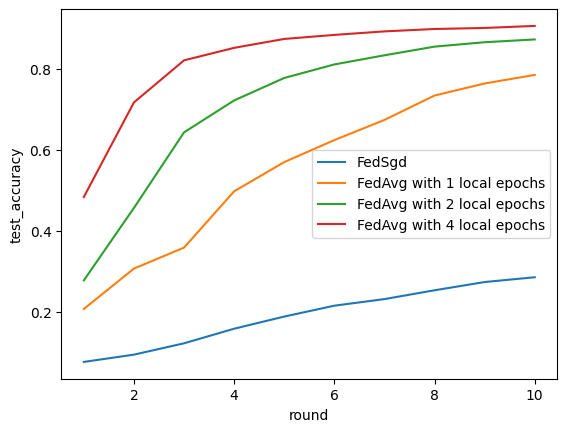

In [20]:
sns.lineplot(results_fedsgd, x="round", y="test_accuracy", label="FedSgd")
for local_epochs, result in zip(local_epochs_variants, results_fedavg_non_iid_local_epochs):
    sns.lineplot(result, x="round", y="test_accuracy", label=f"FedAvg with {local_epochs} local epochs")

We observe that the accuracy of FedAvg increases the more local epochs every client performs.
This matches our intuition according to which weights that were determined using more steps should be generally closer to the optimum than weights that were determined using fewer steps.

Note that in later rounds, the improvement in accuracy when going from 2 to 4 local epochs is not as significant as the improvement from 1 to 2 local epochs.
This is due to the fact that the weights of FedAvg with higher number of local epochs are closer to the optimum than the weights of the other variants, which often implies a decrease in step size.
Note that in the first round, FedAvg with 4 local epochs performs indeed almost 4 times better than FedAvg with just a single local epoch.

To understand why FedAvg with a single local epoch performs better than FedSGD, we need to note that FedAvg performs one optimization step for every mini batch.
FedSGD doesn't use mini batches and therefore only performs a single optimization step.
In other words, FedAvg and FedSGD perform different number of optimization steps even when performing the same number of local epochs.
Our observation therefore follows the same rationale as before.

In [27]:
results_fedsgd_iid = run_fedsgd(iid=True)
results_fedsgd_non_iid = run_fedsgd(iid=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
results_fedavg_iid = run_fedavg(iid=True)
results_fedavg_non_iid = run_fedavg(iid=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='round', ylabel='test_accuracy'>

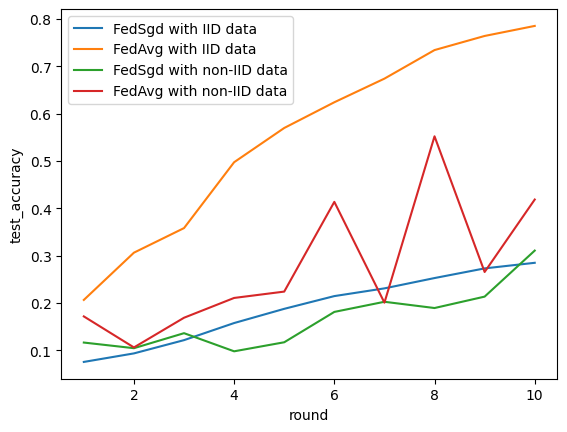

In [30]:
sns.lineplot(results_fedsgd_iid, x="round", y="test_accuracy", label="FedSgd with IID data")
sns.lineplot(results_fedavg_iid, x="round", y="test_accuracy", label="FedAvg with IID data")
sns.lineplot(results_fedsgd_non_iid, x="round", y="test_accuracy", label="FedSgd with non-IID data")
sns.lineplot(results_fedavg_non_iid, x="round", y="test_accuracy", label="FedAvg with non-IID data")


To deal with non-IID data during training, we split the dataset in a way such that every client receives a dataset that contains at most two distinct labels.

FedAvg takes a significant hit on prediction accuracy when operating on non-IDD data, whereas FedSGD doesn't.
As previously discussed, FedSGD calculates the step the same way a single node would, as long as the node uses a batch size that matches the size of the dataset.
The fact that we change the way the data is distributed over clients therefore shouldn't deteriorate accuracy and overall training performance.

In FedAvg, on the other hand, clients perform optimization step themselves.
Reducing the number of labels from 10 to 2 or even 1 significantly reduces the diversity of the dataset, which makes it harder to train a model that is supposed to generalize over all 10 labels.
As the clients start to generalize less, it is also reasonable that the quality of the average over all clients' weights starts to deteriorate as well.
This also serves as an explanation for the observation that the training process is significantly less smooth overall.

To make this more tangible, consider the situation in which one client is assigned the (fairly similar) labels `8` and `9`.
Another client is assigned the (again similar) labels `1` and `7`.
The labels `1` and `8`, however, are very dissimilar, and so are labels `7` and `9`.
It is therefore probably fair to say that the optimization steps performed by those clients are less similar than they would be if both clients trained on datasets containing the same set of labels.


In [32]:
learning_rate_variants = [learning_rate, 0.001]
client_fraction_variants = [active_clients_fraction, 0.5]

In [33]:
results_fedsgd_non_iid = [
    run_fedsgd(
        iid=False,
        active_clients_fraction=client_fraction,
        learning_rate=learning_rate,
    )
    for learning_rate, client_fraction in zip(
        learning_rate_variants, client_fraction_variants
    )
]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
local_epochs_variants = [1, 2, 4]

results_fedavg_non_iid = [
    [
        run_fedavg(
            iid=False,
            local_epochs=local_epochs,
            active_clients_fraction=client_fraction,
            learning_rate=learning_rate,
        )
        for local_epochs in tqdm(
            local_epochs_variants, "local epoch variants", leave=False
        )
    ]
    for learning_rate, client_fraction in tqdm(
        zip(learning_rate_variants, client_fraction_variants),
        "learning rate/fraction variants",
        leave=False,
    )
]

learning rate/fraction variants: 0it [00:00, ?it/s]

local epoch variants:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/10 [00:00<?, ?it/s]

local epoch variants:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

clients:   0%|          | 0/50 [00:00<?, ?it/s]

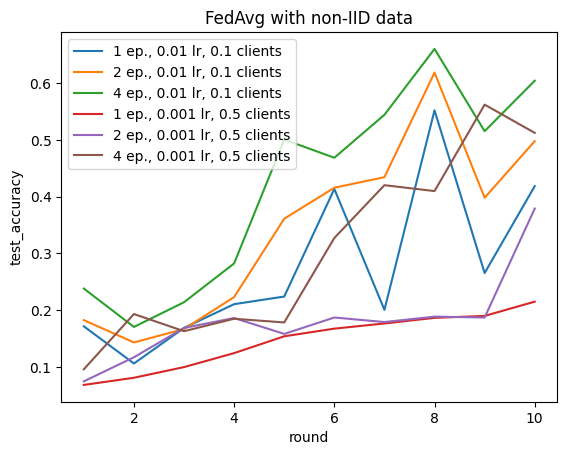

In [45]:
for learning_rate, client_fraction, fedsgd_result, fedavg_results in zip(
    learning_rate_variants,
    client_fraction_variants,
    results_fedsgd_non_iid,
    results_fedavg_non_iid,
):
    for local_epochs, fedavg_result in zip(local_epochs_variants, fedavg_results):
        sns.lineplot(
            fedavg_result,
            x="round",
            y="test_accuracy",
            label=f"{local_epochs} ep., {learning_rate} lr, {client_fraction} clients",
        ).set_title("FedAvg with non-IID data")

The least stable configurations are the ones with the lowest number of clients and with the highest learning rate.
This matches our intuition, since a larger number of clients implies that the average is taken over a larger number of weights.
Similarly, a higher learning rate causes every client to take larger steps, which causes the dissimilarities in the weights due to the differences in the clients' datasets to be more pronounced.

In a similar vein, we observe that a larger number of epochs generally decreases stability.
The effect outlined for the learning rate is a possible explanation approach for this phenomenon.